# Predicting 'kudos' counts based on various metadata on AO3

I have scraped and randomly sampled approximately 25% of works published on AO3 in The Scum Villain's Self-Saving System fandom written in English between 01.10.2022 and 30.09.2023.


# Data import

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from collections import Counter
from scipy.stats import pointbiserialr
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, learning_curve, train_test_split

In [ ]:
df = pd.read_csv('year_of_fandom.csv')

# Data cleaning and preprocessing

**Overview of the data: NaN counts and data types**

In [ ]:
# Create a dictionary with column names, NaN counts, data types for easy viewing
data = {
    'Column': df.columns,
    'NaN Count': [df[col].isna().sum() for col in df.columns],
    'Dtype': df.dtypes
}

# Create a DataFrame from the dictionary
result_df = pd.DataFrame(data)
result_df.reset_index(drop=True, inplace=True)

result_df

,Column,NaN Count,Dtype
0,Work ID,0,int64
1,URL,0,object
2,Title,0,object
3,Authors,0,object
4,Fandoms,0,object
5,Language,0,object
6,Warnings,0,object
7,Ratings,0,object
8,Categories,0,object
9,Characters,30,object


The dataset is mostly clean, thanks to the scraper handling data cleanup during the collection process. The presence of a few NaN values in columns like 'Characters', 'Relationships', and 'Tags' is expected, as not every work will have them (they're not required and are optional for authors).

In [ ]:
# Check the number of rows before
df.shape[0]

1021

**Filtering works based on date range: between 2022-10-01 and 2023-09-30**

In [ ]:
unknown_count = (df['Date Published'] == 'Unknown').sum()
print(f"Number of rows with 'Unknown' in 'Date Published': {unknown_count}")

Number of rows with 'Unknown' in 'Date Published': 4


The scraper was designed to make an additional request to access each work's individual page to extract the 'Date Published'. In instances where there might have been an issue with retrieving this data, the scraper defaults to labeling the date as "Unknown".

In [ ]:
# Filter off "Unknown" published dates
df = df.dropna(subset=['Date Published'])
df = df[df['Date Published'].astype(str) != 'Unknown']

In [ ]:
# Convert the "Date Published" and "Date Updated" column to datetime type
df["Date Published"] = pd.to_datetime(df["Date Published"].copy())
df["Date Updated"] = pd.to_datetime(df["Date Updated"].copy())

# Define the date range
start_date = "2022-10-01"
end_date = "2023-09-30"

# Create a mask
mask = (df["Date Published"] >= start_date) & (df["Date Published"] <= end_date)

# Apply the mask
df = df.loc[mask].copy()

# Sort by "Date Updated"
df = df.sort_values(by="Date Published", ascending=True)
df.reset_index(drop=True, inplace=True)

# Set maximum column width to 50
pd.set_option('display.max_colwidth', 50)

df.head()

,Work ID,URL,Title,Authors,Fandoms,Language,Warnings,Ratings,Categories,Characters,...,Words,Date Published,Date Updated,Chapters,Comments,Kudos,Bookmarks,Hits,Collections,Completion Status
0,42064923,https://archiveofourown.org/works/42064923,The King's Courtesy,AkatsukiShin,人渣反派自救系统 - 墨香铜臭 | The Scum Villain's Self-Savi...,English,No Archive Warnings Apply,Teen And Up Audiences,M/M,Shàng Qīnghuá;Mòběi-jūn,...,3165,2022-10-01,2022-10-01,1/1,15,291,21,1844,0,Complete
1,42055590,https://archiveofourown.org/works/42055590,Shen Qingqiu Hates Cults,Sleepymono,人渣反派自救系统 - 墨香铜臭 | The Scum Villain's Self-Savi...,English,Graphic Depictions Of Violence,Not Rated,M/M,Shěn Yuán | Shěn Qīngqiū;Luò Bīnghé;Shàng Qīnghuá,...,1559,2022-10-01,2022-10-01,1/2,6,254,28,2618,0,Incomplete
2,42085191,https://archiveofourown.org/works/42085191,"Stress Relief Idol, Shang Qinghua!",shoujorei,人渣反派自救系统 - 墨香铜臭 | The Scum Villain's Self-Savi...,English,Creator Chose Not To Use Archive Warnings,Explicit,M/M,Shàng Qīnghuá;Luò Bīnghé;Yuè Qīngyuán;Liǔ Qīng...,...,6692,2022-10-02,2022-10-02,1/2,33,168,25,2886,0,Incomplete
3,42078570,https://archiveofourown.org/works/42078570,The Sour and the Sweet | 两傻吃醋,Anonymous,人渣反派自救系统 - 墨香铜臭 | The Scum Villain's Self-Savi...,English,No Archive Warnings Apply,Teen And Up Audiences,M/M,Original Shěn Qīngqiū;Yuè Qīngyuán,...,10660,2022-10-02,2022-10-02,1/1,31,168,31,1147,1,Complete
4,42085296,https://archiveofourown.org/works/42085296,[ART] Abyss!Shen Yuan,n_m,人渣反派自救系统 - 墨香铜臭 | The Scum Villain's Self-Savi...,English,No Archive Warnings Apply,General Audiences,Gen,Shěn Yuán | Shěn Qīngqiū,...,0,2022-10-02,2022-10-22,2/2,50,984,46,9997,0,Complete


In [ ]:
# Check the number of rows after
df.shape[0]

900

Now we have a dataset that represents a full year's worth of works.

**Adding a column for the number of days since the work was published**

In [ ]:
def days_since_scraping(published_date):
      days_difference = (scraping_date - published_date).days
      return days_difference

# Define the scraping date
scraping_date = datetime(2023, 10, 7)

# Apply the function, create a new column
df['Days Since Publication'] = df['Date Published'].apply(days_since_scraping)

df.head()

,Work ID,URL,Title,Authors,Fandoms,Language,Warnings,Ratings,Categories,Characters,...,Date Published,Date Updated,Chapters,Comments,Kudos,Bookmarks,Hits,Collections,Completion Status,Days Since Publication
0,42064923,https://archiveofourown.org/works/42064923,The King's Courtesy,AkatsukiShin,人渣反派自救系统 - 墨香铜臭 | The Scum Villain's Self-Savi...,English,No Archive Warnings Apply,Teen And Up Audiences,M/M,Shàng Qīnghuá;Mòběi-jūn,...,2022-10-01,2022-10-01,1/1,15,291,21,1844,0,Complete,371
1,42055590,https://archiveofourown.org/works/42055590,Shen Qingqiu Hates Cults,Sleepymono,人渣反派自救系统 - 墨香铜臭 | The Scum Villain's Self-Savi...,English,Graphic Depictions Of Violence,Not Rated,M/M,Shěn Yuán | Shěn Qīngqiū;Luò Bīnghé;Shàng Qīnghuá,...,2022-10-01,2022-10-01,1/2,6,254,28,2618,0,Incomplete,371
2,42085191,https://archiveofourown.org/works/42085191,"Stress Relief Idol, Shang Qinghua!",shoujorei,人渣反派自救系统 - 墨香铜臭 | The Scum Villain's Self-Savi...,English,Creator Chose Not To Use Archive Warnings,Explicit,M/M,Shàng Qīnghuá;Luò Bīnghé;Yuè Qīngyuán;Liǔ Qīng...,...,2022-10-02,2022-10-02,1/2,33,168,25,2886,0,Incomplete,370
3,42078570,https://archiveofourown.org/works/42078570,The Sour and the Sweet | 两傻吃醋,Anonymous,人渣反派自救系统 - 墨香铜臭 | The Scum Villain's Self-Savi...,English,No Archive Warnings Apply,Teen And Up Audiences,M/M,Original Shěn Qīngqiū;Yuè Qīngyuán,...,2022-10-02,2022-10-02,1/1,31,168,31,1147,1,Complete,370
4,42085296,https://archiveofourown.org/works/42085296,[ART] Abyss!Shen Yuan,n_m,人渣反派自救系统 - 墨香铜臭 | The Scum Villain's Self-Savi...,English,No Archive Warnings Apply,General Audiences,Gen,Shěn Yuán | Shěn Qīngqiū,...,2022-10-02,2022-10-22,2/2,50,984,46,9997,0,Complete,370


The information in 'Days Since Publication' hopefully will be useful for understanding how the age of a work might correlate with other metrics.

**Transforming chapter counts into numericals.**

In [ ]:
# Transform chapters to numerical format
df['Published Chapters'] = df['Chapters'].apply(lambda x: int(x.split('/')[0]) if pd.notnull(x) else 0)

df[['Chapters', 'Published Chapters']].head()

,Chapters,Published Chapters
0,1/1,1
1,1/2,1
2,1/2,1
3,1/1,1
4,2/2,2


 The 'Chapters' column originally displayed the number of published chapters relative to the total planned chapters for a work, formatted as **published chapters/total chapters** with an ? for unknown. For further analysis only the published chapters are needed.

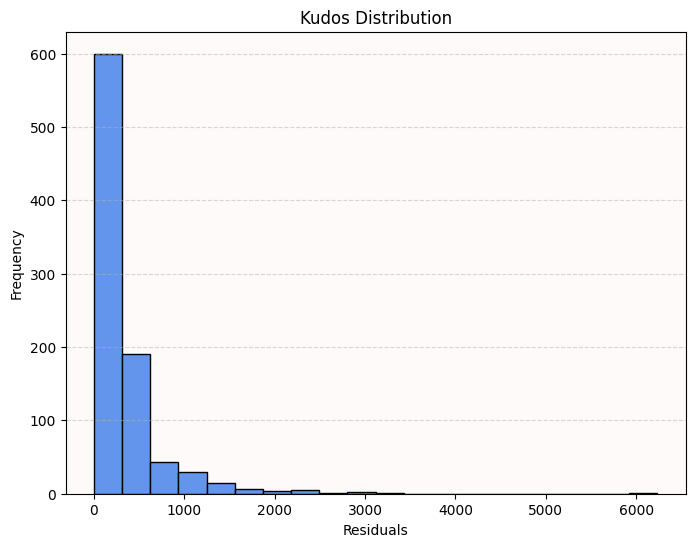

In [ ]:
# Create a histogram plot
plt.figure(figsize=(8, 6))
plt.hist(df['Kudos'], bins=20, color='cornflowerblue', edgecolor='k')

# Add labels
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Kudos Distribution")

# Add grid and background
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.gca().set_facecolor('snow')

# Save as png
plt.savefig("kudos_histogram.png", dpi=300, bbox_inches='tight')

plt.show()

The distribution is highly right-skewed, there are a few outliers with a very high number of kudos compared to the majority.

Maybe a log or SQRT transformation is needed and, of course, a model that deals well with a skewed distribution.

# Exploratory data analysis

**Encoding tags, characters, relationships, authors, completion status, warnings, categories, ratings, fandoms**


In [ ]:
X_full = df.drop('Kudos', axis=1)  # Drop the target column
y_full = df['Kudos']

# Split the data into train and test sets for full feature set
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

In [ ]:
def one_hot_encode_column(df, column_name, min_frequency=10):
    # Split the column into lists
    df[column_name] = df[column_name].apply(lambda x: x.split(';') if pd.notna(x) else [])

    # Count the frequencies of each unique value in the column
    counter = Counter()
    for row in df[column_name]:
        counter.update(row)

    # Keep only the values that have a frequency above min_frequency
    frequent_labels = {key for key, value in counter.items() if value >= min_frequency}

    # Filter the column values based on frequent_labels
    df[column_name] = df[column_name].apply(lambda x: [label for label in x if label in frequent_labels])

    # Initialize MLB
    mlb = MultiLabelBinarizer()

    # One-hot encode the column
    one_hot_data = mlb.fit_transform(df[column_name])
    one_hot_df = pd.DataFrame(one_hot_data, columns=mlb.classes_)

    # Calculate the number of one-hot encoded columns
    num_one_hot_columns = one_hot_df.shape[1]

    print(f"{num_one_hot_columns} one-hot encoded {column_name.lower()}")

    return one_hot_df

In [ ]:
# List of columns
columns_to_encode = ['Tags', 'Characters', 'Relationships', 'Authors', 'Completion Status', 'Warnings', 'Categories', 'Ratings', 'Fandoms']

# One-hot encoding for the training set
one_hot_dfs_train = {}
for column in columns_to_encode:
    one_hot_dfs_train[column] = one_hot_encode_column(X_all_train.copy(), column)

80 one-hot encoded tags
31 one-hot encoded characters
21 one-hot encoded relationships
3 one-hot encoded authors
2 one-hot encoded completion status
6 one-hot encoded warnings
7 one-hot encoded categories
5 one-hot encoded ratings
6 one-hot encoded fandoms


Categories, ratings, and warnings etc. are standardized across the platform. Tags, characters, and relationships, on the other hand, are more varied and user-generated. We'll be looking at features that were at least 10 times in the database.

**Checking correlations between encoded features and kudos**

In [ ]:
def calculate_strong_correlations(one_hot_df, target_series, correlation_threshold=0.1):

    strong_correlations = {}

    # Remove constant columns
    non_constant_columns = one_hot_df.columns[one_hot_df.nunique() > 1]

    for col in non_constant_columns:
        corr, _ = pointbiserialr(one_hot_df[col], target_series)
        if abs(corr) > correlation_threshold:
            strong_correlations[col] = corr

    # Sort by absolute value of correlations
    strong_correlations = {k: v for k, v in sorted(strong_correlations.items(), key=lambda item: abs(item[1]), reverse=True)}

    return strong_correlations

In [ ]:
# Dictionary for strong correlations
strong_correlations_dict_train = {}

# Loop through each one-hot-encoded DF
for column, one_hot_df in one_hot_dfs_train.items():
    strong_correlations = calculate_strong_correlations(one_hot_df, y_all_train.reset_index(drop=True))
    strong_correlations_dict_train[column] = strong_correlations

# Collecting features with strong correlation for the model
strong_features = []
for column, correlations in strong_correlations_dict_train.items():
    for feature, corr_value in correlations.items():
        if abs(corr_value) > 0.1:
            strong_features.append(feature)

# Create a dictionary to store each set of strong correlations
strong_correlations_dataframes_train = {}

min_occurrences = 10

# Loop through to create DataFrames of strong correlations
for column, strong_correlations in strong_correlations_dict_train.items():
    if len(strong_correlations) > 0:
        temp_df = pd.DataFrame(list(strong_correlations.items()), columns=['Feature', 'Correlation with Kudos'])
        strong_correlations_dataframes_train[column] = temp_df


# Loop through to add counts
for column, strong_corr_df in strong_correlations_dataframes_train.items():
    counts = []
    valid_indices = []  # To store the indices of the features that meet the minimum occurrence criteria

    for index, row in strong_corr_df.iterrows():
        feature = row['Feature']

        # Count the number of times the feature appears in the training set
        count = X_all_train[column].apply(lambda x: feature in x.split(';') if pd.notna(x) else False).sum()

        # Check if the count meets the threshold
        if count >= min_occurrences:
            valid_indices.append(index)
            counts.append(count)

    # Filter the DataFrame and add the counts as a new column
    strong_corr_df = strong_corr_df.loc[valid_indices]
    strong_corr_df['Count'] = counts
    strong_correlations_dataframes_train[column] = strong_corr_df

In [ ]:
pd.set_option('display.max_colwidth', None)

def display_all_strong_correlations(correlations_dict):
    all_dfs = []
    for column_name, df in correlations_dict.items():
        if df is not None and not df.empty:
            df = df.copy()
            df['Source Column'] = column_name
            all_dfs.append(df)

    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        display(combined_df)
    else:
        print("No strong correlations were found.")

display_all_strong_correlations(strong_correlations_dataframes_train)

,Feature,Correlation with Kudos,Count,Source Column
0,Unreliable Narrator,0.219482,12,Tags
1,Slow Burn,0.189004,24,Tags
2,Alternate Universe,0.187406,28,Tags
3,Transmigrator Shěn Yuán | Shěn Qīngqiū,0.164432,18,Tags
4,Shěn Jiǔ | Original Shěn Qīngqiū and Shěn Yuán | Shěn Qīngqiū are Not the Same Person,0.155220,20,Tags
5,Oblivious Shěn Yuán | Shěn Qīngqiū,0.152795,39,Tags
6,Alpha/Beta/Omega Dynamics,0.128219,27,Tags
7,Other Additional Tags to Be Added,0.128161,42,Tags
8,Happy Ending,0.122961,31,Tags
9,Time Travel,0.111544,11,Tags


Features with a correlation over 0.1. Mostly tags, with the highest correlation approx. 0.22, one character, one relationship and one category.

**Creating a heatmap for other features and kudos**

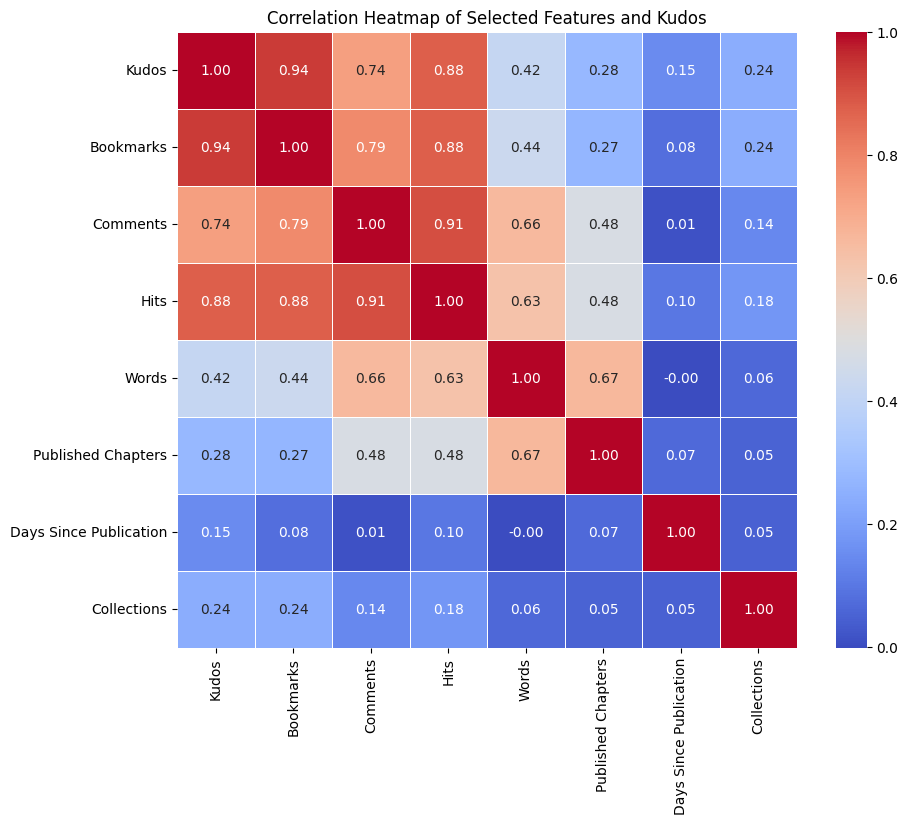

In [ ]:
# Select the features
features_for_correlation = ['Kudos', 'Bookmarks', 'Comments', 'Hits', 'Words','Published Chapters', 'Days Since Publication', 'Collections']

# Calculate the correlation matrix
correlation_matrix = df[features_for_correlation].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, fmt=".2f", linewidths=0.5, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Selected Features and Kudos")

# Save as png
plt.savefig("heatmap.png", dpi=300, bbox_inches='tight')

plt.show()

A high correlation between these four: kudos, bookmarks, comments and hits, which is not surprising. They are all engagement metrics, so it makes sense.

Words, comments, hits and published chapters have an interesting correlation, too.

Days since publication and collections: surprisingly low correlation to kudos and other features.

**Creating scatter plots for chosen features**

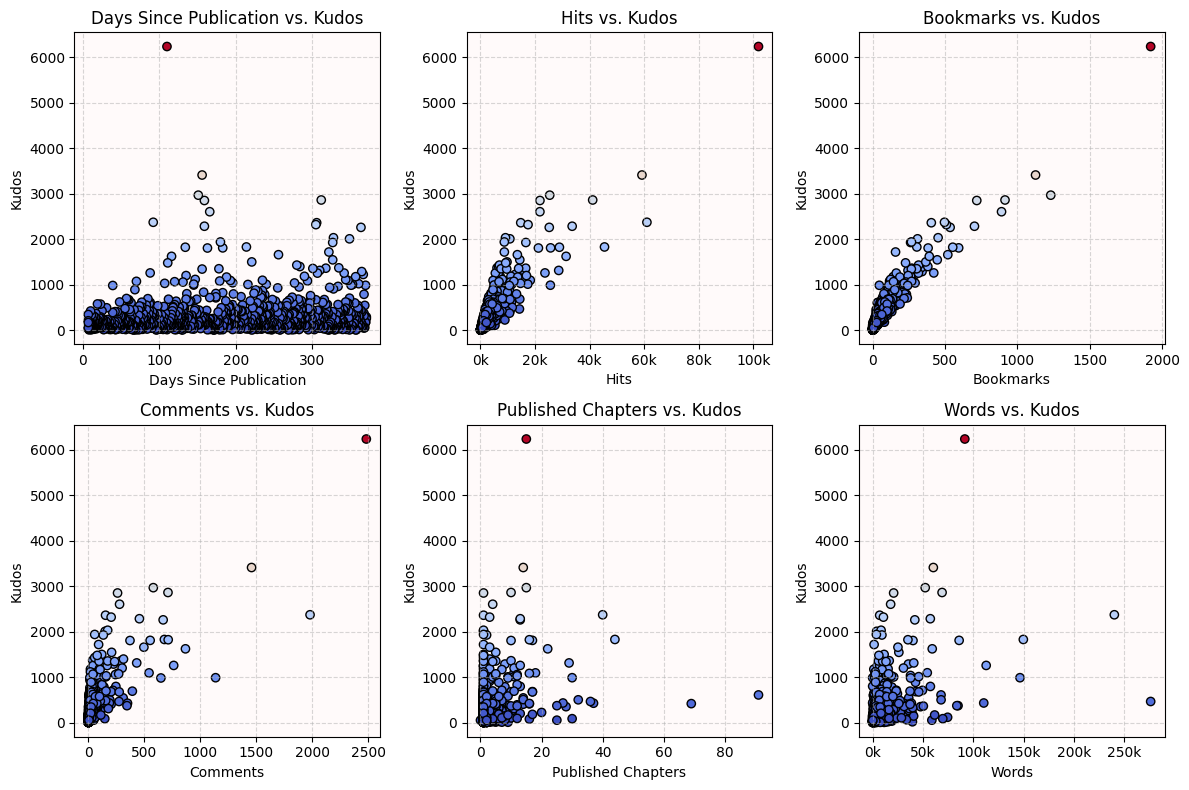

In [ ]:
# Select the features
features_for_plotting = ['Days Since Publication', 'Hits', 'Bookmarks',
                         'Comments', 'Published Chapters', 'Words']

# Calculate number of rows and columns for subplots
n = len(features_for_plotting)
ncols = 3
nrows = math.ceil(n / ncols)

# Create subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 8))

# Flatten the axes array
if nrows > 1:
    axes = axes.flatten()

# Define the colormap
cmap = plt.get_cmap('coolwarm')

# Normalize the kudos values
norm = plt.Normalize(df['Kudos'].min(), df['Kudos'].max())

# Loop over each feature
for i, feature in enumerate(features_for_plotting):
    ax = axes[i]
    scatter = ax.scatter(df[feature], df['Kudos'], c=df['Kudos'], cmap=cmap, norm=norm, alpha=1, edgecolors='k')
    ax.set_ylabel('Kudos')
    ax.set_title(f'{feature} vs. Kudos')
    ax.grid(axis='both', linestyle='--', alpha=0.5)
    ax.set_facecolor('snow')
    ax.set_xlabel(feature)

    # For 'Words' and 'Hits' format in thousands
    if feature.lower() == 'words' or feature.lower() == 'hits':
        ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}k".format(x / 1000)))

plt.tight_layout()

plt.savefig('features_vs_kudos_subplots.png', dpi=300, bbox_inches='tight')

plt.show()

Shows nicely the correlations, not only when it comes to kudos count but also to other features.

In [ ]:
# Define the features and the target variable
X = df[['Comments', 'Bookmarks', 'Hits', 'Words']]
y = df['Kudos']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the models and evaluation

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Perform 5-fold cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    mean_r2 = np.mean(scores)

    return {
        'Model': model.__class__.__name__,
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'R2 Score': r2,
        'Mean R2 Score (CV)': mean_r2
    }

# Initialize models
rf_model = RandomForestRegressor(random_state=42)
lr_model = LinearRegression()
gbm_model = GradientBoostingRegressor(random_state=42)

# Evaluate models and collect results
rf_results = evaluate_model(rf_model, X_train, y_train, X_test, y_test)
lr_results = evaluate_model(lr_model, X_train, y_train, X_test, y_test)
gbm_results = evaluate_model(gbm_model, X_train, y_train, X_test, y_test)

# Create a DF for results
model_results_df = pd.DataFrame([rf_results, lr_results, gbm_results])

# Sort the results
sorted_model_results_df = model_results_df.sort_values(by='R2 Score', ascending=False)

sorted_model_results_df

,Model,Mean Absolute Error,Mean Squared Error,R2 Score,Mean R2 Score (CV)
2,GradientBoostingRegressor,55.412925,6298.669728,0.964856,0.908545
0,RandomForestRegressor,53.589944,8242.596413,0.954010,0.899289
1,LinearRegression,91.981090,22252.220315,0.875843,0.889605


The results are similiar for the Random Forest model and the Random Boosting.

**Graph for the residuals**

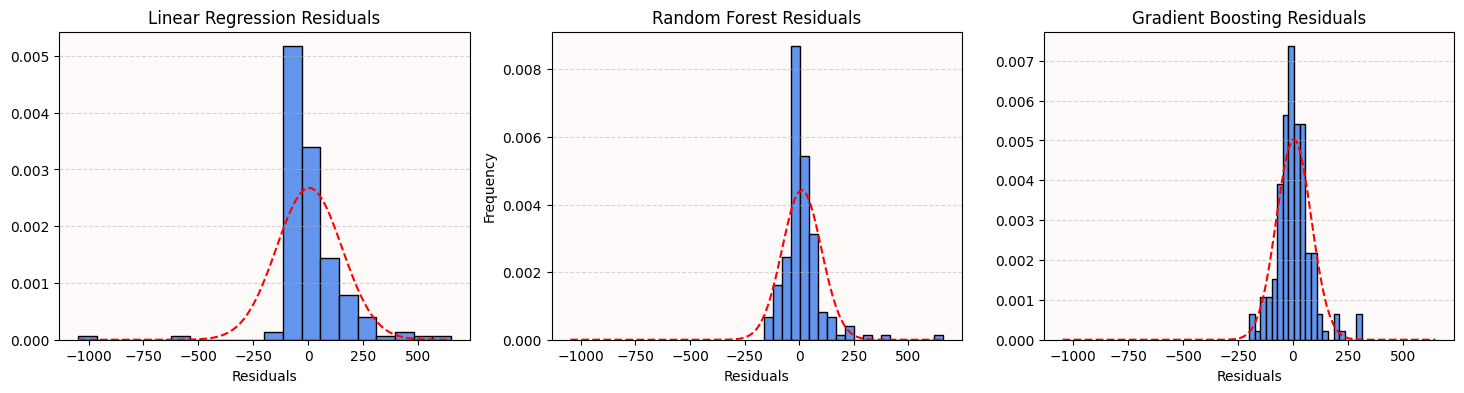

In [ ]:
from scipy.stats import norm

# Make predictions
rf_y_pred = rf_model.predict(X_test)
lr_y_pred = lr_model.predict(X_test)
gbm_y_pred = gbm_model.predict(X_test)

# Calculate the residuals for each model
rf_residuals = y_test - rf_y_pred
lr_residuals = y_test - lr_y_pred
gbm_residuals = y_test - gbm_y_pred

# Create a grid for plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Prepare data for Gaussian curve
x_vals = np.linspace(min(lr_residuals), max(lr_residuals), 100)

# Linear Regression
axes[0].hist(lr_residuals, bins=20, density=True, color='cornflowerblue', edgecolor='k')  # Note the density=True
lr_mu, lr_std = np.mean(lr_residuals), np.std(lr_residuals)
axes[0].plot(x_vals, norm.pdf(x_vals, lr_mu, lr_std), 'r--')
axes[0].set_title("Linear Regression Residuals")
axes[0].set_xlabel("Residuals")
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Random Forest
axes[1].hist(rf_residuals, bins=20, density=True, color='cornflowerblue', edgecolor='k')  # Note the density=True
rf_mu, rf_std = np.mean(rf_residuals), np.std(rf_residuals)
axes[1].plot(x_vals, norm.pdf(x_vals, rf_mu, rf_std), 'r--')
axes[1].set_title("Random Forest Residuals")
axes[1].set_xlabel("Residuals")
axes[1].set_ylabel("Frequency")
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# Gradient Boosting
axes[2].hist(gbm_residuals, bins=20, density=True, color='cornflowerblue', edgecolor='k')  # Note the density=True
gbm_mu, gbm_std = np.mean(gbm_residuals), np.std(gbm_residuals)
axes[2].plot(x_vals, norm.pdf(x_vals, gbm_mu, gbm_std), 'r--')
axes[2].set_title("Gradient Boosting Residuals")
axes[2].set_xlabel("Residuals")
axes[2].grid(axis='y', linestyle='--', alpha=0.5)

# Add background color
for ax in axes:
    ax.set_facecolor('snow')

# Save as png
plt.savefig("all_residual_histograms_with_curve.png", dpi=300, bbox_inches='tight')

plt.show()

**Final graph for predicted vs. observed kudos**

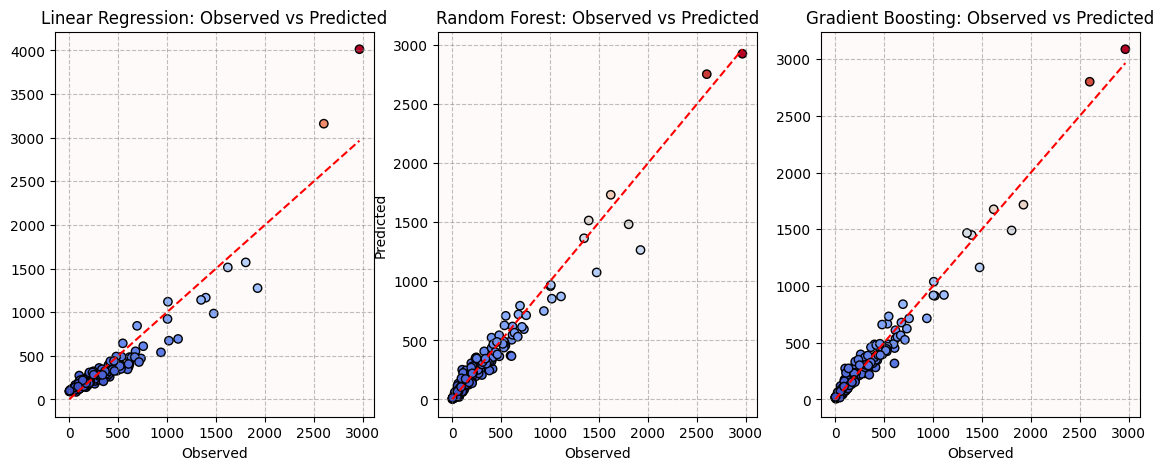

In [ ]:
# Create a grid for plotting
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Prepare data for the regression line
regression_line_x = np.linspace(min(y_test), max(y_test), 100)
regression_line_y = regression_line_x

# Linear Regression
axes[0].scatter(y_test, lr_y_pred, c=lr_y_pred, cmap='coolwarm', alpha=1, edgecolors='k', label='Data Points')
axes[0].plot(regression_line_x, regression_line_y, 'r--')
axes[0].set_title('Linear Regression: Observed vs Predicted')
axes[0].set_xlabel('Observed')
axes[0].grid(color='gray', linestyle='--', alpha=0.5)

# Random Forest
axes[1].scatter(y_test, rf_y_pred, c=rf_y_pred, cmap='coolwarm', alpha=1, edgecolors='k', label='Data Points')
axes[1].plot(regression_line_x, regression_line_y, 'r--')
axes[1].set_title('Random Forest: Observed vs Predicted')
axes[1].set_xlabel('Observed')
axes[1].set_ylabel('Predicted')
axes[1].grid(color='gray', linestyle='--', alpha=0.5)

# Gradient Boosting
axes[2].scatter(y_test, gbm_y_pred, c=gbm_y_pred, cmap='coolwarm', alpha=1, edgecolors='k', label='Data Points')
axes[2].plot(regression_line_x, regression_line_y, 'r--')
axes[2].set_title('Gradient Boosting: Observed vs Predicted')
axes[2].set_xlabel('Observed')
axes[2].grid(color='gray', linestyle='--', alpha=0.5)

# Add background color
for ax in axes:
    ax.set_facecolor('snow')

# Save as png
plt.savefig("all_observed_vs_predicted.png", dpi=300, bbox_inches='tight')

plt.show()

# COnclusion
The project successfully created a model to predict if a work on AO3 is under- or overperforming based on its engagement metrics. The models (Random Forest and Gradient Boosting) are reliable, and the analysis provided insights into what drives a work's popularity.





